# Hidden Markov Model: An implementation

In this notebook, we will implement an Hidden Markov Model in order to identify in which state of volatility we are right now to sell the volatility on the market. For further information on this topic please refer to the EMSE paper which describes the strategy.
An HMM is fully defined by: 

$$
\lambda = (\pi, A, B)
$$

First we will need initial distribution:

$$
\pi_i = P(q_1 = i)
$$
This is the prior belief about the regime at start.

The transition matrix of the Markov process is also relevant: 

$$
A =
\begin{pmatrix}
a_{11} & \cdots & a_{1N} \\
\vdots & \ddots & \vdots \\
a_{N1} & \cdots & a_{NN}
\end{pmatrix}
$$


Where $a_{ii}$ is the regime persistence of the state i and the expected duration of regime i is: $\mathbb{E}[T_i] = \frac{1}{1 - a_{ii}}$

Finally, we need the emission distribution B, if gaussian (which can be requestionned) $O_t \mid q_t = i \sim \mathcal{N}(\mu_i, \Sigma_i)$. We interpret this as each regime has: mean return, volatility, covariance structure. This is how the model learns regime.


We have here a lot of paramters we will try to optimize:

* duration between two observation
* how to cal

We also need to have a good data quality:

* Missing values
* Outliers

Hidden Markov Model:

* Gaussian emission densities with full covariance
* Baum-Welch (EM) algorithm for parameter estimation
* Viterbi decoding for most likely state sequence
* Model selection via AIC/BIC criteria

Let's optimize this hyper parameters:

* number of different states
* Normal law only?
* 

  

source:

https://github.com/I-am-Uchenna/regime-allocation-strategy

In [12]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import threading
import asyncio
import scipy
import seaborn as sns
import statsmodels.api as sm

from ib_insync import *
from ib_insync import IB, Stock, util
from ib_insync import Future
from ib_insync import Stock
from ib_insync import Option
from ib_insync import Bond
from ib_insync import Forex
from ib_insync import Index
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D 
from ipywidgets import interact, FloatSlider, IntSlider, Dropdown
import plotly.graph_objects as go
import plotly.io as pio
from scipy.integrate import quad
from hmmlearn import hmm

pio.renderers.default = "notebook"
%matplotlib widget
%matplotlib ipympl

## Data

In [3]:
ib = IB()
util.startLoop()
await ib.connectAsync('127.0.0.1', 7496, clientId=1) # Don't forget to change the client ID

<IB connected to 127.0.0.1:7496 clientId=1>

Error 200, reqId 36: Aucune d\u00e9finition de titre trouv\u00e9e pour cette requ\u00eate, contract: Stock(symbol='FCHI', exchange='SMART', primaryExchange='SBF', currency='EUR')
Error 200, reqId 37: Aucune d\u00e9finition de titre trouv\u00e9e pour cette requ\u00eate, contract: Stock(symbol='FCHI', exchange='SMART', primaryExchange='SBF', currency='EUR')
Error 200, reqId 40: Aucune d\u00e9finition de titre trouv\u00e9e pour cette requ\u00eate, contract: Stock(symbol='CAC40', exchange='SMART', primaryExchange='SBF', currency='EUR')
Error 200, reqId 41: Aucune d\u00e9finition de titre trouv\u00e9e pour cette requ\u00eate, contract: Stock(symbol='CAC40', exchange='SMART', primaryExchange='SBF', currency='EUR')
Error 200, reqId 54: Aucune d\u00e9finition de titre trouv\u00e9e pour cette requ\u00eate, contract: Stock(symbol='GLD', exchange='SMART', primaryExchange='SBF', currency='EUR')
Error 200, reqId 55: Aucune d\u00e9finition de titre trouv\u00e9e pour cette requ\u00eate, contract: Sto

In [52]:
P = ['GLE','CAC', 'IFRB','GOLD']

In [53]:
async def fetch_stock_df(
    ib,
    symbol,
    exchange,
    currency,
    primaryExchange,
    duration='1 Y',
    barSize='1 day'
):
    contract = Stock(
        symbol=symbol,
        exchange=exchange,
        currency=currency,
        primaryExchange=primaryExchange
    )

    await ib.qualifyContractsAsync(contract)

    bars = await ib.reqHistoricalDataAsync(
        contract,
        endDateTime='',
        durationStr=duration,
        barSizeSetting=barSize,
        whatToShow='TRADES',
        useRTH=True
    )

    df = util.df(bars)
    df = df.set_index('date')[['close']]
    df.rename(columns={'close': symbol}, inplace=True)

    return df


In [54]:
dfs = []

for symbol in P:

    exch, curr, prim = 'SMART', 'EUR', 'SBF'


    df = await fetch_stock_df(
        ib,
        symbol,
        exch,
        curr,
        prim
    )
    dfs.append(df)

prices = pd.concat(dfs, axis=1, join='inner')
prices.sort_index(inplace=True)


In [55]:
prices = pd.concat(dfs, axis=1, join='inner')
prices.sort_index(inplace=True)

prices

,GLE,CAC,IFRB,GOLD
date,,,,
2025-01-30,31.085,78.10,127.54,106.306
2025-01-31,31.210,77.97,128.03,107.192
2025-02-03,30.430,77.06,128.66,108.690
2025-02-04,30.940,77.62,128.55,108.700
2025-02-05,30.725,77.39,129.24,109.340
...,...,...,...,...
2026-01-23,69.620,80.15,125.23,168.035
2026-01-26,71.300,80.15,125.64,169.286
2026-01-27,72.450,80.35,125.80,168.876


In [72]:
log_returns = np.log(prices / prices.shift(1))
log_returns

,GLE,CAC,IFRB,GOLD
date,,,,
2025-01-30,NaN,NaN,NaN,NaN
2025-01-31,0.004013,-0.001666,0.003835,0.008300
2025-02-03,-0.025310,-0.011740,0.004909,0.013878
2025-02-04,0.016621,0.007241,-0.000855,0.000092
2025-02-05,-0.006973,-0.002968,0.005353,0.005870
...,...,...,...,...
2026-01-23,-0.015535,-0.002119,0.001199,0.020241
2026-01-26,0.023844,0.000000,0.003269,0.007417
2026-01-27,0.016000,0.002492,0.001273,-0.002425


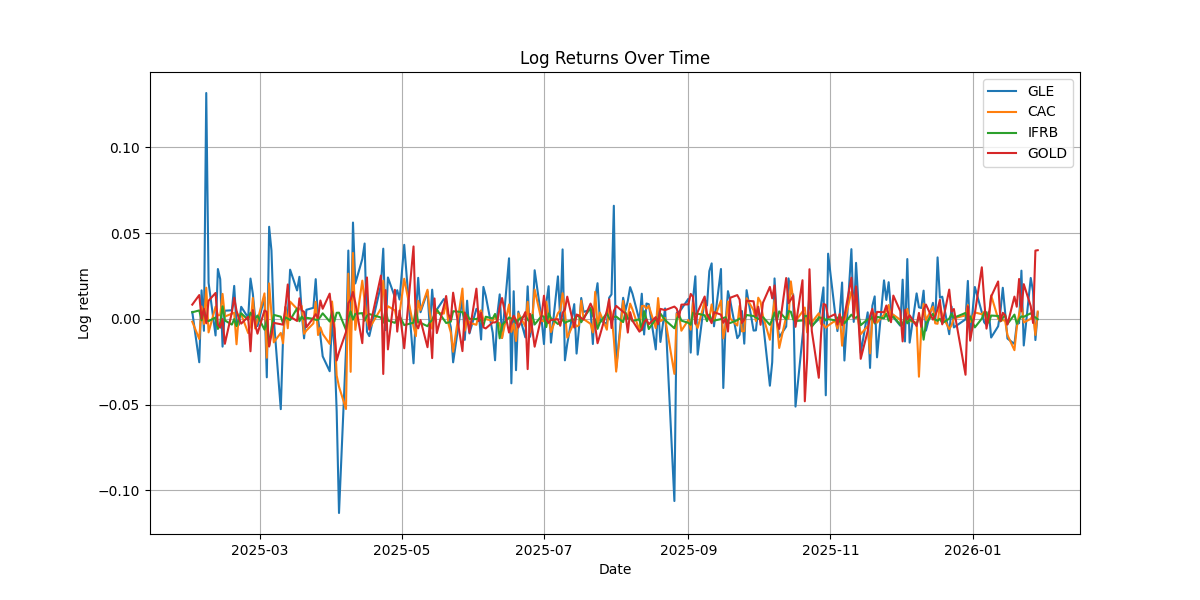

In [75]:
plt.figure(figsize=(12, 6))

for col in log_returns.columns:
    plt.plot(log_returns.index, log_returns[col], label=col)

plt.title("Log Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Log return")
plt.legend()
plt.grid(True)
plt.show()

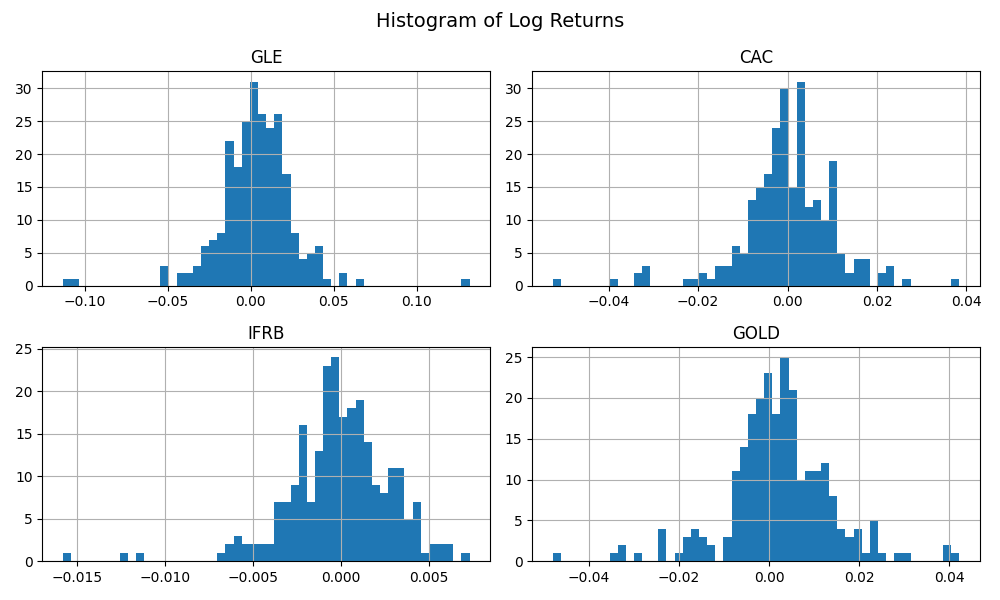

In [76]:
log_returns.hist(
    bins=50,
    figsize=(10, 6),
    grid=True
)

plt.suptitle("Histogram of Log Returns", fontsize=14)
plt.tight_layout()
plt.show()

## Model

Let's fit a 3 states Gaussian Markov Model:

In [77]:
model = hmm.GaussianHMM(n_components=2, covariance_type='full', n_iter=1000, random_state=42)


NameError: name 'vix_changes' is not defined


Data columns: MultiIndex([( 'Close',  'GLD'),
            ( 'Close',  'SPY'),
            ( 'Close',  'TLT'),
            ( 'Close', '^VIX'),
            (  'High',  'GLD'),
            (  'High',  'SPY'),
            (  'High',  'TLT'),
            (  'High', '^VIX'),
            (   'Low',  'GLD'),
            (   'Low',  'SPY'),
            (   'Low',  'TLT'),
            (   'Low', '^VIX'),
            (  'Open',  'GLD'),
            (  'Open',  'SPY'),
            (  'Open',  'TLT'),
            (  'Open', '^VIX'),
            ('Volume',  'GLD'),
            ('Volume',  'SPY'),
            ('Volume',  'TLT'),
            ('Volume', '^VIX')],
           names=['Price', 'Ticker'])
Data shape: (5553, 20)

Price columns: ['GLD', 'SPY', 'TLT', 'VIX']
Price data shape: (5553, 4)
GLD: 5331 observations from 2004-11-18 to 2026-01-28
SPY: 5553 observations from 2004-01-02 to 2026-01-28
TLT: 5553 observations from 2004-01-02 to 2026-01-28
VIX: 5553 observations from 2004-01-02 to 2026-01-2

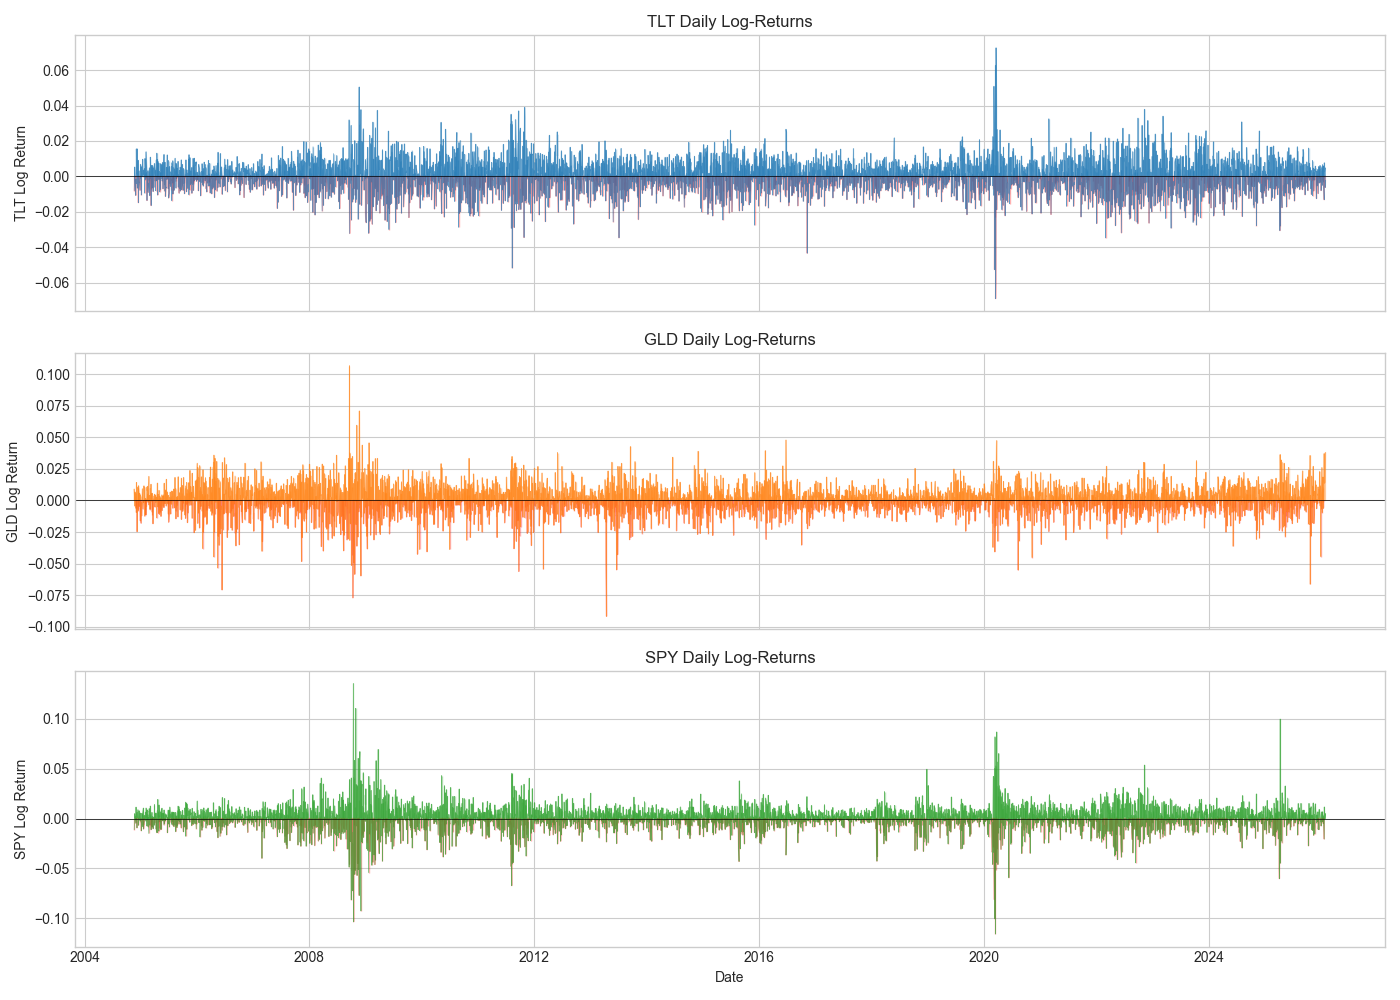

Figure 1: ETF daily log-returns showing the volatility clustering pattern across all three assets.


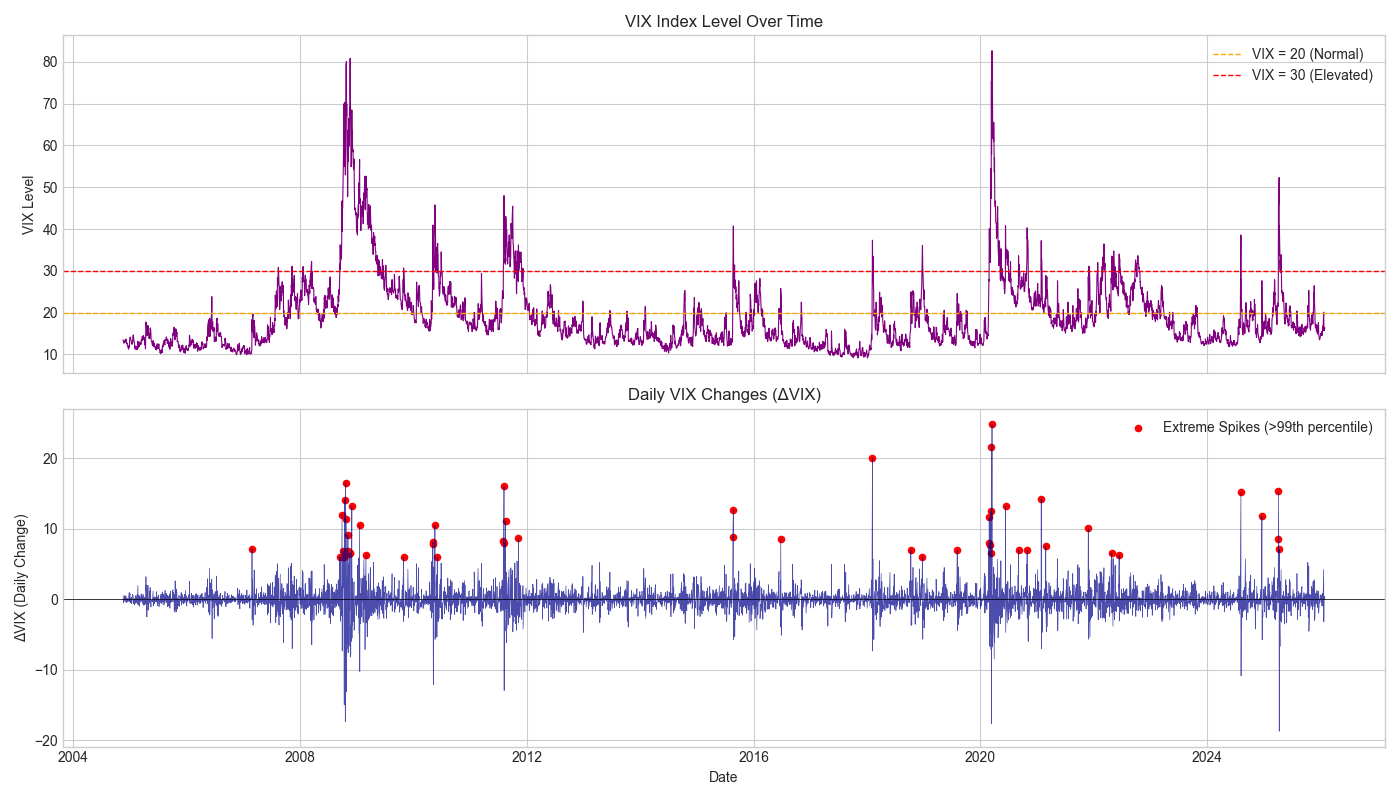

Figure 2: VIX level and daily changes showing volatility regime transitions.

=== Data Quality Check ===
Missing values in log_returns:
TLT           0
GLD           0
SPY           0
VIX_change    0
VIX_return    0
dtype: int64

Data range: 2004-11-19 to 2026-01-28
Total trading days: 5330

=== Outlier Detection (values beyond 5 standard deviations) ===
TLT: 8 outliers detected
GLD: 10 outliers detected
SPY: 20 outliers detected
VIX_change: 30 outliers detected
VIX_return: 14 outliers detected
=== Discretization Results ===

2-State Distribution:
0    2677
1    2653
Name: count, dtype: int64

3-State Distribution:
0    1762
1    1823
2    1745
Name: count, dtype: int64

=== 2-State Transition Matrix ===
               To Low Vol  To High Vol
From Low Vol       0.4852       0.5148
From High Vol      0.5196       0.4804

=== 3-State Transition Matrix ===
             To Low  To Medium  To High
From Low     0.3490     0.3093   0.3417
From Medium  0.2333     0.4402   0.3266
From High    0

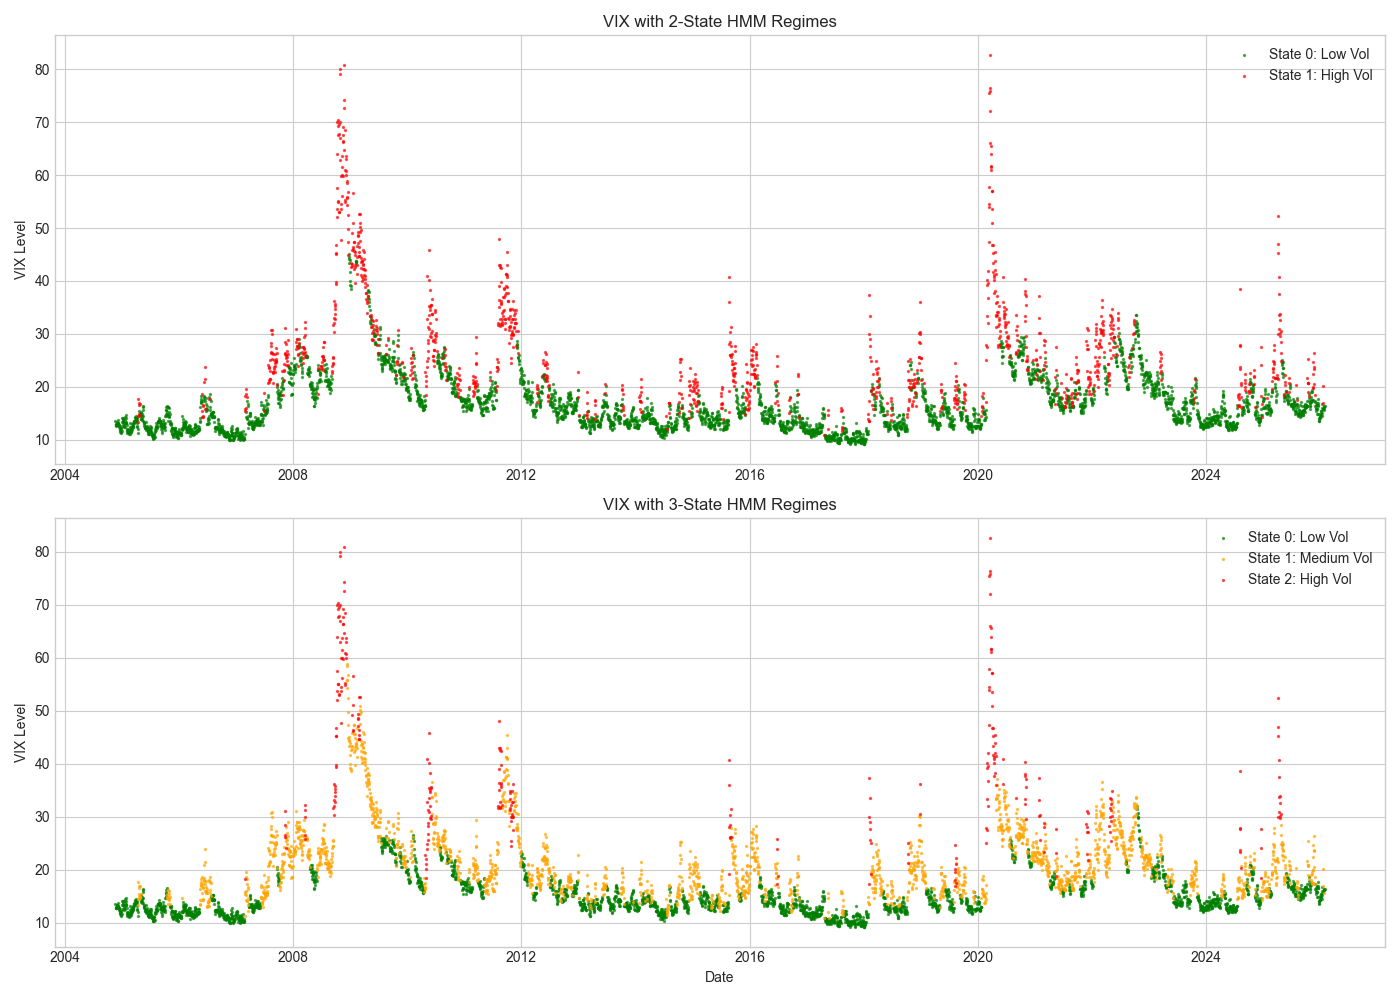


=== Model Comparison Table ===
      Model  Parameters  Log-Likelihood          AIC          BIC
2-State HMM           7    -9059.747541 18133.495082 18179.562828
3-State HMM          14    -8716.226037 17460.452074 17552.587565

Best model based on BIC: 3-State HMM

=== Model Selection Decision ===

SELECTED MODEL: 2-State HMM

RATIONALE:
1. BIC Comparison: 2-State BIC = 18179.56, 3-State BIC = 17552.59
   - 3-State has lower BIC

2. Interpretability:
   - 2 states correspond well to "risk-on" vs "risk-off" market environments
   - Clear mapping to traditional volatility regimes

3. Practical Implementation:
   - Simpler allocation rules
   - Fewer regime transitions (lower turnover)
   - Easier to explain to stakeholders

4. State Characteristics:
   - State 0 (Low Vol): Decreasing or stable VIX, calm markets
   - State 1 (High Vol): Increasing VIX, market stress


=== State-Conditional ETF Returns (Annualized) ===

Mean Returns:
State  High Vol  Low Vol
ETF                     
GLD

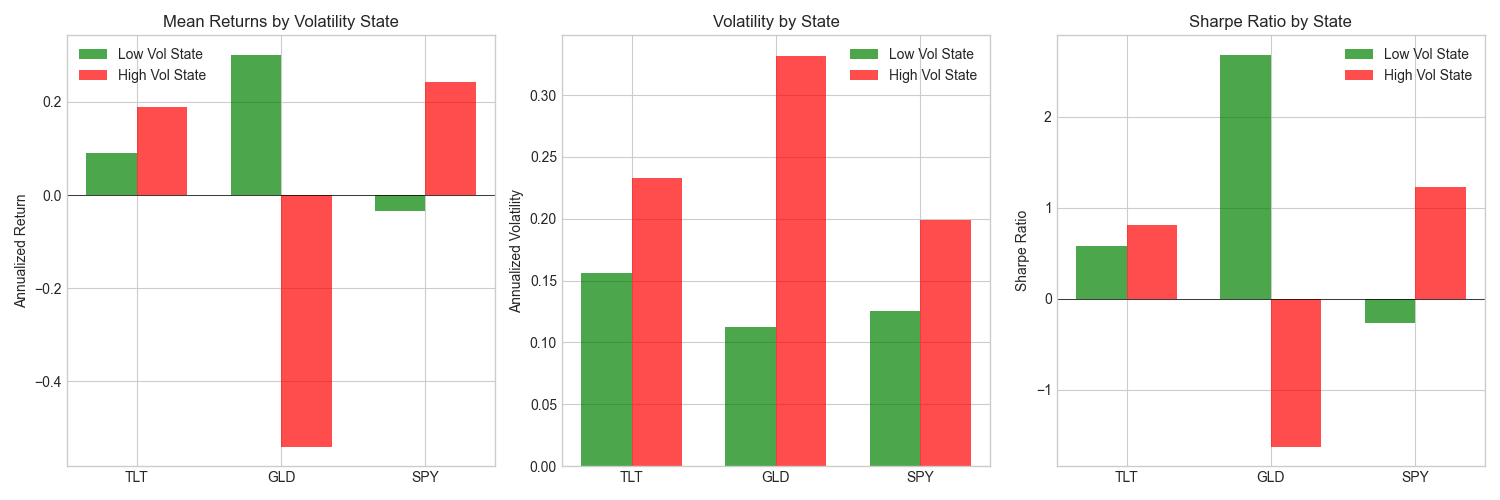


=== Determining Optimal Allocations by State ===

Low Vol State (State 0):
  SPY: 0.3007 (annualized)
  GLD: 0.0906 (annualized)
  TLT: -0.0338 (annualized)
  Best ETF: SPY

High Vol State (State 1):
  TLT: 0.2434 (annualized)
  GLD: 0.1895 (annualized)
  SPY: -0.5398 (annualized)
  Best ETF: TLT

=== Final Allocation Rules ===
             State  TLT Weight  GLD Weight  SPY Weight       Interpretation
 Low Vol (State 0)         0.0           0         1.0    Risk-On: Equities
High Vol (State 1)         1.0           0         0.0 Risk-Off: Safe Haven

=== Strategy Design Rationale ===

ALLOCATION LOGIC:
1. In LOW VOLATILITY states (risk-on environment):
   - VIX is declining or stable
   - Market sentiment is optimistic
   - Allocate to the best-performing asset in calm markets

2. In HIGH VOLATILITY states (risk-off environment):
   - VIX is rising
   - Market stress and uncertainty
   - Allocate to defensive/safe-haven assets

EXECUTION RULES:
- Use 1-day execution lag to avoid loo

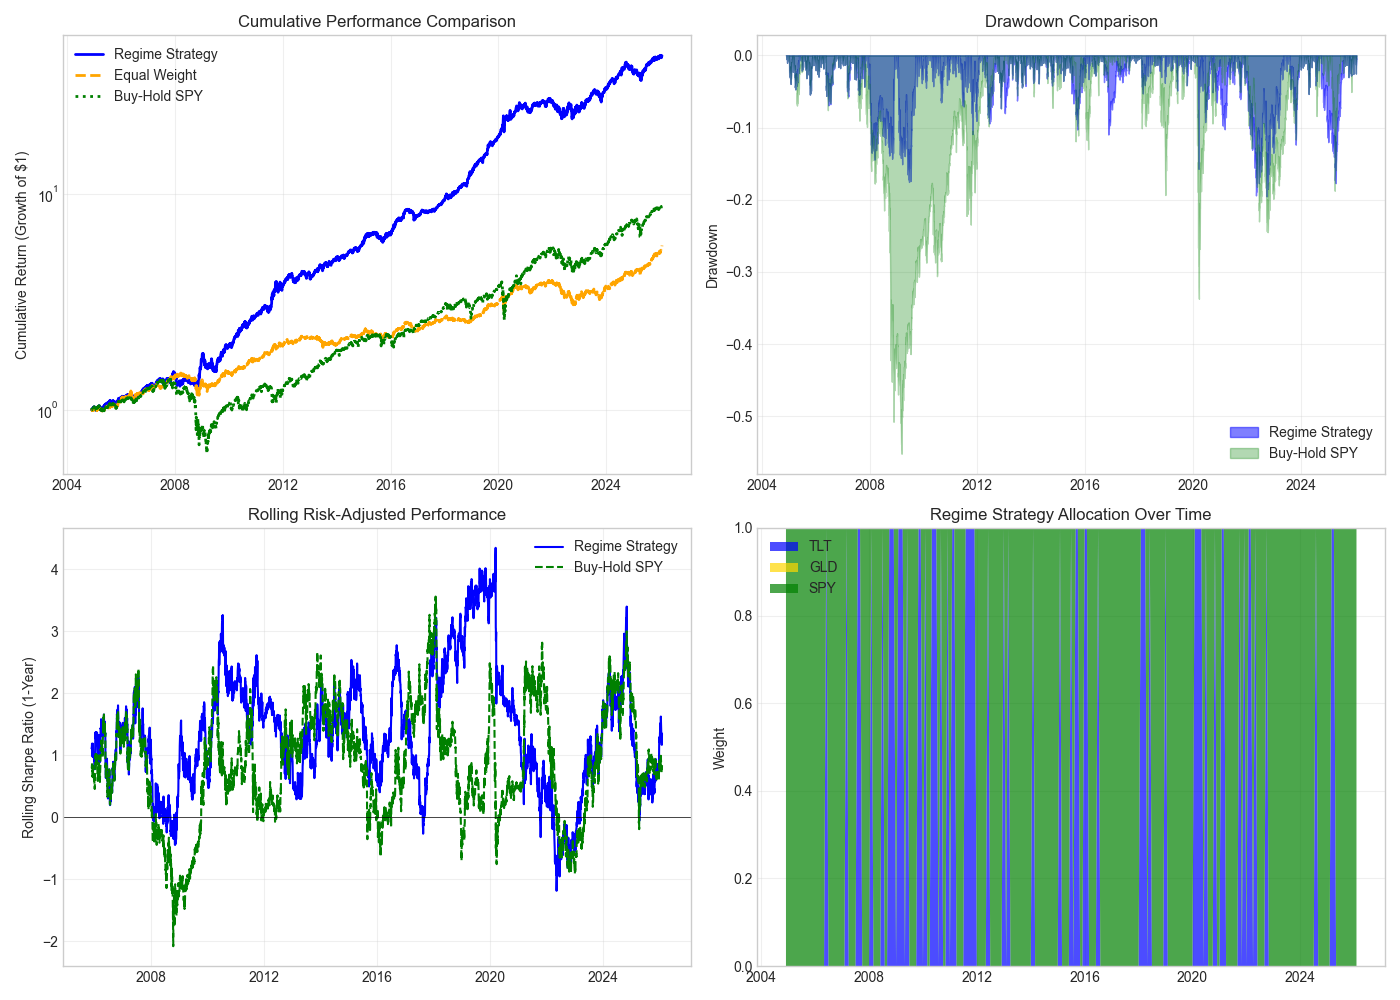

Benchmarks created successfully.
Equal-weight returns: 5329 days
SPY returns: 5329 days

=== Performance Summary Table ===
       Strategy Cumulative Return Annualized Return Annualized Volatility Sharpe Ratio Max Drawdown Sortino Ratio Calmar Ratio
Regime Strategy          4227.75%            19.50%                14.27%        1.226      -19.54%         1.679        0.998
   Equal Weight           475.77%             8.63%                 9.65%        0.687      -23.45%         0.938        0.368
   Buy-Hold SPY           777.19%            10.81%                19.00%        0.464      -55.19%         0.551        0.196


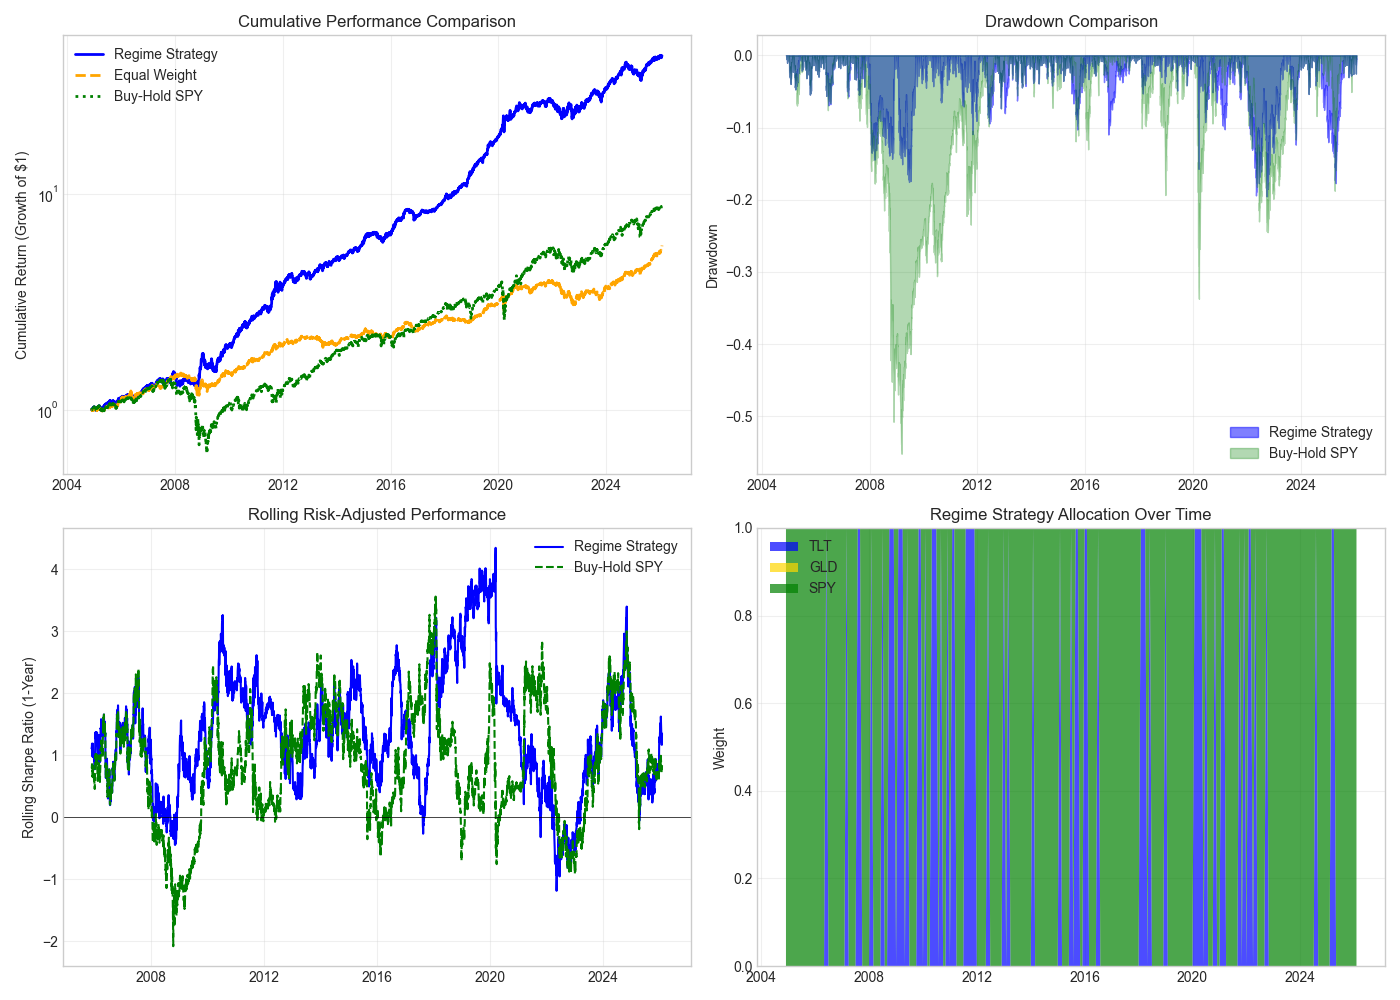


=== Sensitivity Analysis: Number of States ===
   Strategy Annualized Return Annualized Volatility Sharpe Ratio Max Drawdown
2-State HMM            19.50%                14.27%        1.226      -19.54%
3-State HMM            17.49%                14.93%        1.037      -26.23%

EXECUTIVE SUMMARY - REGIME-BASED ALLOCATION STRATEGY

METHODOLOGY:
- Used Hidden Markov Models to identify volatility regimes from VIX dynamics
- Selected 2-state model (Low Vol / High Vol) for interpretability
- Designed rule-based allocation rotating among TLT, GLD, and SPY
- Implemented with 1-day execution lag to avoid lookahead bias

KEY FINDINGS:
1. VIX dynamics exhibit clear regime-switching behavior
2. ETF returns show distinct patterns across volatility states
3. Regime-based allocation provides systematic risk management

STRATEGY PERFORMANCE:
- The regime strategy adapts allocation based on market conditions
- Performance relative to benchmarks depends on:
  * Accuracy of regime identification
  *

In [78]:
# -*- coding: utf-8 -*-
"""regime_allocation_strategy

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1E3xe8Mvci2MKIHrwkzTYgY1WszZjIW8X
"""

# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-whitegrid')

# Download data for TLT, GLD, SPY, and VIX
tickers = ['TLT', 'GLD', 'SPY', '^VIX']
ticker_names = ['TLT', 'GLD', 'SPY', 'VIX']

# Download maximum available data
print("Downloading data from Yahoo Finance...")

# Download all tickers at once
data = yf.download(tickers, start='2004-01-01', end=datetime.today().strftime('%Y-%m-%d'), progress=False)

# Check the structure of downloaded data
print(f"\nData columns: {data.columns}")
print(f"Data shape: {data.shape}")

# Extract Adjusted Close (or Close if Adj Close not available)
if 'Adj Close' in data.columns.get_level_values(0):
    prices = data['Adj Close'].copy()
elif 'Close' in data.columns.get_level_values(0):
    prices = data['Close'].copy()
else:
    # Handle single-level columns
    prices = data.copy()

# Rename ^VIX to VIX
if '^VIX' in prices.columns:
    prices = prices.rename(columns={'^VIX': 'VIX'})

print(f"\nPrice columns: {prices.columns.tolist()}")
print(f"Price data shape: {prices.shape}")

# Check data availability for each ticker
for col in prices.columns:
    valid_data = prices[col].dropna()
    print(f"{col}: {len(valid_data)} observations from {valid_data.index[0].strftime('%Y-%m-%d')} to {valid_data.index[-1].strftime('%Y-%m-%d')}")

# Find common sample period and align data
prices = prices.dropna()
print(f"\nCommon sample period: {prices.index[0].strftime('%Y-%m-%d')} to {prices.index[-1].strftime('%Y-%m-%d')}")
print(f"Total observations: {len(prices)}")

# Display first few rows
print("\nFirst 5 rows of price data:")
print(prices.head())

# Compute daily log-returns for ETFs
etf_tickers = ['TLT', 'GLD', 'SPY']
log_returns = pd.DataFrame()

for ticker in etf_tickers:
    log_returns[ticker] = np.log(prices[ticker] / prices[ticker].shift(1))

# Compute VIX change (difference) and VIX return
log_returns['VIX_change'] = prices['VIX'].diff()  # Absolute change in VIX
log_returns['VIX_return'] = np.log(prices['VIX'] / prices['VIX'].shift(1))  # Log return of VIX

# Remove first row with NaN values
log_returns = log_returns.dropna()

# Display summary statistics
print("\n=== Summary Statistics for Daily Log-Returns ===")
print(log_returns[etf_tickers].describe())

print("\n=== Summary Statistics for VIX Changes ===")
print(log_returns[['VIX_change', 'VIX_return']].describe())

# Figure 1: ETF Returns Over Time
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

colors = {'TLT': '#1f77b4', 'GLD': '#ff7f0e', 'SPY': '#2ca02c'}

for i, ticker in enumerate(etf_tickers):
    axes[i].plot(log_returns.index, log_returns[ticker], color=colors[ticker], alpha=0.7, linewidth=0.5)
    axes[i].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[i].set_ylabel(f'{ticker} Log Return')
    axes[i].set_title(f'{ticker} Daily Log-Returns')
    axes[i].fill_between(log_returns.index, log_returns[ticker], 0,
                         where=log_returns[ticker] > 0, color=colors[ticker], alpha=0.3)
    axes[i].fill_between(log_returns.index, log_returns[ticker], 0,
                         where=log_returns[ticker] < 0, color='red', alpha=0.3)

axes[2].set_xlabel('Date')
plt.tight_layout()
plt.savefig('etf_returns_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure 1: ETF daily log-returns showing the volatility clustering pattern across all three assets.")

# Figure 2: VIX Changes Over Time
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot VIX level
axes[0].plot(prices.loc[log_returns.index, 'VIX'], color='purple', linewidth=0.8)
axes[0].set_ylabel('VIX Level')
axes[0].set_title('VIX Index Level Over Time')
axes[0].axhline(y=20, color='orange', linestyle='--', linewidth=1, label='VIX = 20 (Normal)')
axes[0].axhline(y=30, color='red', linestyle='--', linewidth=1, label='VIX = 30 (Elevated)')
axes[0].legend()

# Plot VIX change (ΔVIX)
axes[1].plot(log_returns.index, log_returns['VIX_change'], color='darkblue', alpha=0.7, linewidth=0.5)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_ylabel('ΔVIX (Daily Change)')
axes[1].set_title('Daily VIX Changes (ΔVIX)')
axes[1].set_xlabel('Date')

# Highlight extreme VIX spikes
vix_spikes = log_returns['VIX_change'] > log_returns['VIX_change'].quantile(0.99)
axes[1].scatter(log_returns.index[vix_spikes], log_returns.loc[vix_spikes, 'VIX_change'],
                color='red', s=20, label='Extreme Spikes (>99th percentile)')
axes[1].legend()

plt.tight_layout()
plt.savefig('vix_changes_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure 2: VIX level and daily changes showing volatility regime transitions.")

# Verify data consistency
print("\n=== Data Quality Check ===")
print(f"Missing values in log_returns:\n{log_returns.isnull().sum()}")
print(f"\nData range: {log_returns.index[0].strftime('%Y-%m-%d')} to {log_returns.index[-1].strftime('%Y-%m-%d')}")
print(f"Total trading days: {len(log_returns)}")

# Check for outliers
print("\n=== Outlier Detection (values beyond 5 standard deviations) ===")
for col in log_returns.columns:
    mean_val = log_returns[col].mean()
    std_val = log_returns[col].std()
    outliers = log_returns[np.abs(log_returns[col] - mean_val) > 5 * std_val]
    print(f"{col}: {len(outliers)} outliers detected")



# Step 2: Modeling VIX Regimes

# Discretize ΔVIX into states using quantiles
def discretize_vix_changes(vix_changes, n_states=3):
    """
    Discretize VIX changes into n_states using quantile-based thresholds.
    """
    if n_states == 2:
        threshold = vix_changes.quantile(0.5)
        states = pd.Series(np.where(vix_changes <= threshold, 0, 1), index=vix_changes.index)
        state_labels = {0: 'Low Vol', 1: 'High Vol'}
    elif n_states == 3:
        q33 = vix_changes.quantile(0.33)
        q67 = vix_changes.quantile(0.67)
        conditions = [
            vix_changes <= q33,
            (vix_changes > q33) & (vix_changes <= q67),
            vix_changes > q67
        ]
        states = pd.Series(np.select(conditions, [0, 1, 2]), index=vix_changes.index)
        state_labels = {0: 'Low Vol', 1: 'Medium Vol', 2: 'High Vol'}

    return states, state_labels

# Create 2-state and 3-state discretizations
states_2, labels_2 = discretize_vix_changes(log_returns['VIX_change'], n_states=2)
states_3, labels_3 = discretize_vix_changes(log_returns['VIX_change'], n_states=3)

print("=== Discretization Results ===")
print(f"\n2-State Distribution:\n{states_2.value_counts().sort_index()}")
print(f"\n3-State Distribution:\n{states_3.value_counts().sort_index()}")

# Estimate Transition Matrix
def estimate_transition_matrix(states, n_states):
    """
    Estimate transition matrix from state sequence.
    """
    transition_counts = np.zeros((n_states, n_states))

    for i in range(len(states) - 1):
        current_state = int(states.iloc[i])
        next_state = int(states.iloc[i + 1])
        transition_counts[current_state, next_state] += 1

    # Normalize to get probabilities
    row_sums = transition_counts.sum(axis=1, keepdims=True)
    transition_matrix = transition_counts / row_sums

    return transition_matrix, transition_counts

# 2-State Markov Chain
trans_matrix_2, counts_2 = estimate_transition_matrix(states_2, 2)
print("\n=== 2-State Transition Matrix ===")
trans_df_2 = pd.DataFrame(trans_matrix_2,
                          index=['From Low Vol', 'From High Vol'],
                          columns=['To Low Vol', 'To High Vol'])
print(trans_df_2.round(4))

# 3-State Markov Chain
trans_matrix_3, counts_3 = estimate_transition_matrix(states_3, 3)
print("\n=== 3-State Transition Matrix ===")
trans_df_3 = pd.DataFrame(trans_matrix_3,
                          index=['From Low', 'From Medium', 'From High'],
                          columns=['To Low', 'To Medium', 'To High'])
print(trans_df_3.round(4))

# Compute Stationary Distribution
def compute_stationary_distribution(trans_matrix):
    """
    Compute stationary distribution of Markov chain.
    """
    eigenvalues, eigenvectors = np.linalg.eig(trans_matrix.T)

    # Find eigenvector corresponding to eigenvalue 1
    idx = np.argmin(np.abs(eigenvalues - 1))
    stationary = np.real(eigenvectors[:, idx])
    stationary = stationary / stationary.sum()

    return stationary

stat_dist_2 = compute_stationary_distribution(trans_matrix_2)
stat_dist_3 = compute_stationary_distribution(trans_matrix_3)

print("\n=== Stationary Distributions ===")
print(f"2-State: Low Vol = {stat_dist_2[0]:.4f}, High Vol = {stat_dist_2[1]:.4f}")
print(f"3-State: Low = {stat_dist_3[0]:.4f}, Medium = {stat_dist_3[1]:.4f}, High = {stat_dist_3[2]:.4f}")

# Install hmmlearn if needed
!pip install hmmlearn -q

from hmmlearn import hmm

# Prepare data for HMM
vix_data = log_returns['VIX_change'].values.reshape(-1, 1)

# Fit 2-State Gaussian HMM
np.random.seed(42)
hmm_2 = hmm.GaussianHMM(n_components=2, covariance_type='full', n_iter=1000, random_state=42)
hmm_2.fit(vix_data)

# Extract parameters
print("\n=== 2-State HMM Parameters ===")
print(f"Means: {hmm_2.means_.flatten()}")
print(f"Variances: {hmm_2.covars_.flatten()}")
print(f"Transition Matrix:\n{hmm_2.transmat_}")
print(f"Initial State Probabilities: {hmm_2.startprob_}")
print(f"Log-Likelihood: {hmm_2.score(vix_data):.2f}")

# Get most likely state sequence (Viterbi)
hidden_states_2 = hmm_2.predict(vix_data)

# Get smoothed probabilities
state_probs_2 = hmm_2.predict_proba(vix_data)

# Fit 3-State Gaussian HMM
np.random.seed(42)
hmm_3 = hmm.GaussianHMM(n_components=3, covariance_type='full', n_iter=1000, random_state=42)
hmm_3.fit(vix_data)

print("\n=== 3-State HMM Parameters ===")
print(f"Means: {hmm_3.means_.flatten()}")
print(f"Transition Matrix:\n{hmm_3.transmat_}")
print(f"Log-Likelihood: {hmm_3.score(vix_data):.2f}")

# Get most likely state sequence
hidden_states_3 = hmm_3.predict(vix_data)
state_probs_3 = hmm_3.predict_proba(vix_data)

# Sort states by mean (for consistent interpretation)
def sort_hmm_states(hmm_model, states, state_probs):
    """
    Reorder HMM states so that state 0 has lowest mean, etc.
    """
    means = hmm_model.means_.flatten()
    order = np.argsort(means)

    # Create mapping
    new_states = np.zeros_like(states)
    new_probs = np.zeros_like(state_probs)

    for new_idx, old_idx in enumerate(order):
        new_states[states == old_idx] = new_idx
        new_probs[:, new_idx] = state_probs[:, old_idx]

    return new_states, new_probs, order

hidden_states_2_sorted, state_probs_2_sorted, order_2 = sort_hmm_states(hmm_2, hidden_states_2, state_probs_2)
hidden_states_3_sorted, state_probs_3_sorted, order_3 = sort_hmm_states(hmm_3, hidden_states_3, state_probs_3)

# Add to dataframe
log_returns['MC_State_2'] = states_2.values
log_returns['MC_State_3'] = states_3.values
log_returns['HMM_State_2'] = hidden_states_2_sorted
log_returns['HMM_State_3'] = hidden_states_3_sorted

print("\nState sequences added to log_returns DataFrame")
print(f"Columns: {log_returns.columns.tolist()}")

# Plot VIX with color-coded HMM states
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 2-State HMM
colors_2 = {0: 'green', 1: 'red'}
state_names_2 = {0: 'Low Vol', 1: 'High Vol'}

for state in [0, 1]:
    mask = log_returns['HMM_State_2'] == state
    axes[0].scatter(log_returns.index[mask], prices.loc[log_returns.index[mask], 'VIX'],
                   c=colors_2[state], s=2, alpha=0.6,
                   label=f'State {state}: {state_names_2[state]}')

axes[0].set_ylabel('VIX Level')
axes[0].set_title('VIX with 2-State HMM Regimes')
axes[0].legend()

# 3-State HMM
colors_3 = {0: 'green', 1: 'orange', 2: 'red'}
state_names_3 = {0: 'Low Vol', 1: 'Medium Vol', 2: 'High Vol'}

for state in [0, 1, 2]:
    mask = log_returns['HMM_State_3'] == state
    axes[1].scatter(log_returns.index[mask], prices.loc[log_returns.index[mask], 'VIX'],
                   c=colors_3[state], s=2, alpha=0.6,
                   label=f'State {state}: {state_names_3[state]}')

axes[1].set_ylabel('VIX Level')
axes[1].set_xlabel('Date')
axes[1].set_title('VIX with 3-State HMM Regimes')
axes[1].legend()

plt.tight_layout()
plt.savefig('vix_regimes_hmm.png', dpi=150, bbox_inches='tight')
plt.show()



# Step 3: State Selection and Interpretation

# Calculate AIC and BIC for model comparison
def calculate_hmm_metrics(hmm_model, data, n_states):
    """
    Calculate log-likelihood, AIC, and BIC for HMM.
    """
    n_samples = len(data)
    log_likelihood = hmm_model.score(data)

    # Number of parameters for Gaussian HMM with full covariance:
    # - (n_states - 1) initial probabilities
    # - n_states * (n_states - 1) transition probabilities
    # - n_states means (for 1D data)
    # - n_states variances (for 1D data with full covariance)
    n_params = (n_states - 1) + n_states * (n_states - 1) + n_states + n_states

    aic = 2 * n_params - 2 * log_likelihood
    bic = np.log(n_samples) * n_params - 2 * log_likelihood

    return log_likelihood, aic, bic, n_params

# Calculate metrics for HMM models
ll_2, aic_2, bic_2, params_2 = calculate_hmm_metrics(hmm_2, vix_data, 2)
ll_3, aic_3, bic_3, params_3 = calculate_hmm_metrics(hmm_3, vix_data, 3)

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': ['2-State HMM', '3-State HMM'],
    'Parameters': [params_2, params_3],
    'Log-Likelihood': [ll_2, ll_3],
    'AIC': [aic_2, aic_3],
    'BIC': [bic_2, bic_3]
})

print("\n=== Model Comparison Table ===")
print(comparison_df.to_string(index=False))

# Determine best model based on BIC (penalizes complexity more)
best_model = '2-State HMM' if bic_2 < bic_3 else '3-State HMM'
print(f"\nBest model based on BIC: {best_model}")

# Select preferred model (we'll use 2-state for interpretability)
print("\n=== Model Selection Decision ===")

if bic_2 < bic_3:
    selection_reason = "2-State HMM selected based on lower BIC, indicating better parsimony."
else:
    selection_reason = "Although 3-State HMM has lower BIC, we select 2-State for interpretability."

print(f"""
SELECTED MODEL: 2-State HMM

RATIONALE:
1. BIC Comparison: 2-State BIC = {bic_2:.2f}, 3-State BIC = {bic_3:.2f}
   - {'2-State has lower BIC (preferred)' if bic_2 < bic_3 else '3-State has lower BIC'}

2. Interpretability:
   - 2 states correspond well to "risk-on" vs "risk-off" market environments
   - Clear mapping to traditional volatility regimes

3. Practical Implementation:
   - Simpler allocation rules
   - Fewer regime transitions (lower turnover)
   - Easier to explain to stakeholders

4. State Characteristics:
   - State 0 (Low Vol): Decreasing or stable VIX, calm markets
   - State 1 (High Vol): Increasing VIX, market stress
""")

# Use 2-State HMM for strategy
selected_states = log_returns['HMM_State_2'].copy()
n_selected_states = 2

# Compute mean and standard deviation of ETF returns by state
state_returns_stats = []

for state in range(n_selected_states):
    mask = selected_states == state
    state_name = 'Low Vol' if state == 0 else 'High Vol'

    for etf in etf_tickers:
        mean_ret = log_returns.loc[mask, etf].mean() * 252  # Annualized
        std_ret = log_returns.loc[mask, etf].std() * np.sqrt(252)  # Annualized
        sharpe = mean_ret / std_ret if std_ret > 0 else 0

        state_returns_stats.append({
            'State': state_name,
            'ETF': etf,
            'Mean Return (Ann.)': mean_ret,
            'Volatility (Ann.)': std_ret,
            'Sharpe Ratio': sharpe,
            'Observations': mask.sum()
        })

state_returns_df = pd.DataFrame(state_returns_stats)

print("\n=== State-Conditional ETF Returns (Annualized) ===")
pivot_mean = state_returns_df.pivot(index='ETF', columns='State', values='Mean Return (Ann.)')
pivot_std = state_returns_df.pivot(index='ETF', columns='State', values='Volatility (Ann.)')
pivot_sharpe = state_returns_df.pivot(index='ETF', columns='State', values='Sharpe Ratio')

print("\nMean Returns:")
print(pivot_mean.round(4))
print("\nVolatility:")
print(pivot_std.round(4))
print("\nSharpe Ratios:")
print(pivot_sharpe.round(4))

# Visualize with bar chart
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Mean Returns by State
x = np.arange(len(etf_tickers))
width = 0.35

ax1 = axes[0]
bars1 = ax1.bar(x - width/2, pivot_mean['Low Vol'], width, label='Low Vol State', color='green', alpha=0.7)
bars2 = ax1.bar(x + width/2, pivot_mean['High Vol'], width, label='High Vol State', color='red', alpha=0.7)
ax1.set_ylabel('Annualized Return')
ax1.set_title('Mean Returns by Volatility State')
ax1.set_xticks(x)
ax1.set_xticklabels(etf_tickers)
ax1.legend()
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Volatility by State
ax2 = axes[1]
bars3 = ax2.bar(x - width/2, pivot_std['Low Vol'], width, label='Low Vol State', color='green', alpha=0.7)
bars4 = ax2.bar(x + width/2, pivot_std['High Vol'], width, label='High Vol State', color='red', alpha=0.7)
ax2.set_ylabel('Annualized Volatility')
ax2.set_title('Volatility by State')
ax2.set_xticks(x)
ax2.set_xticklabels(etf_tickers)
ax2.legend()

# Sharpe Ratio by State
ax3 = axes[2]
bars5 = ax3.bar(x - width/2, pivot_sharpe['Low Vol'], width, label='Low Vol State', color='green', alpha=0.7)
bars6 = ax3.bar(x + width/2, pivot_sharpe['High Vol'], width, label='High Vol State', color='red', alpha=0.7)
ax3.set_ylabel('Sharpe Ratio')
ax3.set_title('Sharpe Ratio by State')
ax3.set_xticks(x)
ax3.set_xticklabels(etf_tickers)
ax3.legend()
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig('state_conditional_returns.png', dpi=150, bbox_inches='tight')
plt.show()



# Step 4: Designing the Rotation Strategy

# Determine best ETF for each state based on historical performance
print("\n=== Determining Optimal Allocations by State ===")

allocation_rules = {}
for state in range(n_selected_states):
    state_name = 'Low Vol' if state == 0 else 'High Vol'
    mask = selected_states == state

    # Calculate mean returns for each ETF in this state
    etf_means = {}
    for etf in etf_tickers:
        etf_means[etf] = log_returns.loc[mask, etf].mean()

    # Sort by performance
    sorted_etfs = sorted(etf_means.items(), key=lambda x: x[1], reverse=True)
    best_etf = sorted_etfs[0][0]
    second_best = sorted_etfs[1][0]

    print(f"\n{state_name} State (State {state}):")
    for etf, mean_ret in sorted_etfs:
        print(f"  {etf}: {mean_ret*252:.4f} (annualized)")
    print(f"  Best ETF: {best_etf}")

    # 100% to best ETF
    allocation_rules[state] = {best_etf: 1.0}

print("\n=== Final Allocation Rules ===")
allocation_table = pd.DataFrame({
    'State': ['Low Vol (State 0)', 'High Vol (State 1)'],
    'TLT Weight': [allocation_rules[0].get('TLT', 0), allocation_rules[1].get('TLT', 0)],
    'GLD Weight': [allocation_rules[0].get('GLD', 0), allocation_rules[1].get('GLD', 0)],
    'SPY Weight': [allocation_rules[0].get('SPY', 0), allocation_rules[1].get('SPY', 0)],
    'Interpretation': ['Risk-On: Equities', 'Risk-Off: Safe Haven']
})
print(allocation_table.to_string(index=False))

# Strategy Justification
print("""
=== Strategy Design Rationale ===

ALLOCATION LOGIC:
1. In LOW VOLATILITY states (risk-on environment):
   - VIX is declining or stable
   - Market sentiment is optimistic
   - Allocate to the best-performing asset in calm markets

2. In HIGH VOLATILITY states (risk-off environment):
   - VIX is rising
   - Market stress and uncertainty
   - Allocate to defensive/safe-haven assets

EXECUTION RULES:
- Use 1-day execution lag to avoid lookahead bias
- Today's observed state determines tomorrow's allocation
- Rebalance daily based on regime signals

EXPECTED BENEFITS:
- Capture equity upside during calm markets
- Protect capital during market stress through flight-to-quality
- Systematic, rules-based approach removes emotional decision-making
""")



# Step 5: Backtesting and Evaluation

# Implement backtest with 1-day execution lag
def backtest_strategy(returns_df, states, allocation_rules, lag=1):
    """
    Backtest regime-based allocation strategy.
    """
    etf_cols = ['TLT', 'GLD', 'SPY']

    # Shift states by lag days (yesterday's state determines today's allocation)
    lagged_states = states.shift(lag)

    # Initialize output
    strategy_returns = pd.Series(index=returns_df.index, dtype=float)
    weights_history = pd.DataFrame(index=returns_df.index, columns=etf_cols, dtype=float)

    for date in returns_df.index[lag:]:
        state = int(lagged_states.loc[date])
        weights = allocation_rules.get(state, {etf: 1/3 for etf in etf_cols})

        # Calculate weighted return
        daily_return = 0
        for etf in etf_cols:
            weight = weights.get(etf, 0)
            daily_return += weight * returns_df.loc[date, etf]
            weights_history.loc[date, etf] = weight

        strategy_returns.loc[date] = daily_return

    return strategy_returns.dropna(), weights_history.dropna()

# Backtest regime strategy
strategy_returns, weights_history = backtest_strategy(
    log_returns[etf_tickers],
    selected_states,
    allocation_rules,
    lag=1
)

print(f"Strategy backtest period: {strategy_returns.index[0].strftime('%Y-%m-%d')} to {strategy_returns.index[-1].strftime('%Y-%m-%d')}")
print(f"Total trading days: {len(strategy_returns)}")

# Create Benchmark Strategies

# Benchmark 1: Equal-weight portfolio (monthly rebalanced approximation)
equal_weight_rets = log_returns[etf_tickers].mean(axis=1)
equal_weight_rets = equal_weight_rets.loc[strategy_returns.index]

# Benchmark 2: Buy-and-hold SPY
spy_returns = log_returns['SPY'].loc[strategy_returns.index]

print("Benchmarks created successfully.")
print(f"Equal-weight returns: {len(equal_weight_rets)} days")
print(f"SPY returns: {len(spy_returns)} days")

# Calculate Performance Metrics
def calculate_performance_metrics(returns, name="Strategy", rf_rate=0.02):
    """
    Calculate comprehensive performance metrics.
    """
    ann_factor = 252

    # Cumulative return
    cumulative_return = np.exp(returns.sum()) - 1

    # Annualized return
    n_years = len(returns) / ann_factor
    annualized_return = (1 + cumulative_return) ** (1/n_years) - 1

    # Annualized volatility
    annualized_vol = returns.std() * np.sqrt(ann_factor)

    # Sharpe Ratio
    sharpe_ratio = (annualized_return - rf_rate) / annualized_vol

    # Maximum Drawdown
    cumulative = np.exp(returns.cumsum())
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()

    # Sortino Ratio
    downside_returns = returns[returns < 0]
    downside_vol = downside_returns.std() * np.sqrt(ann_factor)
    sortino_ratio = (annualized_return - rf_rate) / downside_vol if downside_vol > 0 else np.nan

    # Calmar Ratio
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else np.nan

    return {
        'Strategy': name,
        'Cumulative Return': cumulative_return,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_vol,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Sortino Ratio': sortino_ratio,
        'Calmar Ratio': calmar_ratio
    }

# Calculate metrics for all strategies
metrics_regime = calculate_performance_metrics(strategy_returns, "Regime Strategy")
metrics_equal = calculate_performance_metrics(equal_weight_rets, "Equal Weight")
metrics_spy = calculate_performance_metrics(spy_returns, "Buy-Hold SPY")

# Create comparison table
metrics_list = [metrics_regime, metrics_equal, metrics_spy]
metrics_df = pd.DataFrame(metrics_list)

# Format for display
display_df = metrics_df.copy()
display_df['Cumulative Return'] = display_df['Cumulative Return'].apply(lambda x: f"{x:.2%}")
display_df['Annualized Return'] = display_df['Annualized Return'].apply(lambda x: f"{x:.2%}")
display_df['Annualized Volatility'] = display_df['Annualized Volatility'].apply(lambda x: f"{x:.2%}")
display_df['Sharpe Ratio'] = display_df['Sharpe Ratio'].apply(lambda x: f"{x:.3f}")
display_df['Max Drawdown'] = display_df['Max Drawdown'].apply(lambda x: f"{x:.2%}")
display_df['Sortino Ratio'] = display_df['Sortino Ratio'].apply(lambda x: f"{x:.3f}")
display_df['Calmar Ratio'] = display_df['Calmar Ratio'].apply(lambda x: f"{x:.3f}")

print("\n=== Performance Summary Table ===")
print(display_df.to_string(index=False))

# Plot cumulative performance
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Cumulative returns
ax1 = axes[0, 0]
cum_strategy = np.exp(strategy_returns.cumsum())
cum_equal = np.exp(equal_weight_rets.cumsum())
cum_spy = np.exp(spy_returns.cumsum())

ax1.plot(cum_strategy.index, cum_strategy, label='Regime Strategy', linewidth=2, color='blue')
ax1.plot(cum_equal.index, cum_equal, label='Equal Weight', linewidth=2, color='orange', linestyle='--')
ax1.plot(cum_spy.index, cum_spy, label='Buy-Hold SPY', linewidth=2, color='green', linestyle=':')
ax1.set_ylabel('Cumulative Return (Growth of $1)')
ax1.set_title('Cumulative Performance Comparison')
ax1.legend()
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# Drawdown
ax2 = axes[0, 1]
dd_strategy = (cum_strategy - cum_strategy.cummax()) / cum_strategy.cummax()
dd_equal = (cum_equal - cum_equal.cummax()) / cum_equal.cummax()
dd_spy = (cum_spy - cum_spy.cummax()) / cum_spy.cummax()

ax2.fill_between(dd_strategy.index, dd_strategy, 0, alpha=0.5, label='Regime Strategy', color='blue')
ax2.fill_between(dd_spy.index, dd_spy, 0, alpha=0.3, label='Buy-Hold SPY', color='green')
ax2.set_ylabel('Drawdown')
ax2.set_title('Drawdown Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Rolling Sharpe Ratio (252-day)
ax3 = axes[1, 0]
rolling_window = 252
rolling_sharpe_strategy = (strategy_returns.rolling(rolling_window).mean() * 252) / (strategy_returns.rolling(rolling_window).std() * np.sqrt(252))
rolling_sharpe_spy = (spy_returns.rolling(rolling_window).mean() * 252) / (spy_returns.rolling(rolling_window).std() * np.sqrt(252))

ax3.plot(rolling_sharpe_strategy.index, rolling_sharpe_strategy, label='Regime Strategy', color='blue')
ax3.plot(rolling_sharpe_spy.index, rolling_sharpe_spy, label='Buy-Hold SPY', color='green', linestyle='--')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.set_ylabel('Rolling Sharpe Ratio (1-Year)')
ax3.set_title('Rolling Risk-Adjusted Performance')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Allocation over time
ax4 = axes[1, 1]
weights_monthly = weights_history.resample('M').last()
ax4.stackplot(weights_monthly.index,
              weights_monthly['TLT'].fillna(0),
              weights_monthly['GLD'].fillna(0),
              weights_monthly['SPY'].fillna(0),
              labels=['TLT', 'GLD', 'SPY'],
              colors=['blue', 'gold', 'green'],
              alpha=0.7)
ax4.set_ylabel('Weight')
ax4.set_title('Regime Strategy Allocation Over Time')
ax4.legend(loc='upper left')
ax4.set_ylim(0, 1)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('performance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Create Benchmark Strategies

# Benchmark 1: Equal-weight portfolio (monthly rebalanced approximation)
equal_weight_rets = log_returns[etf_tickers].mean(axis=1)
equal_weight_rets = equal_weight_rets.loc[strategy_returns.index]

# Benchmark 2: Buy-and-hold SPY
spy_returns = log_returns['SPY'].loc[strategy_returns.index]

print("Benchmarks created successfully.")
print(f"Equal-weight returns: {len(equal_weight_rets)} days")
print(f"SPY returns: {len(spy_returns)} days")

# Calculate Performance Metrics
def calculate_performance_metrics(returns, name="Strategy", rf_rate=0.02):
    """
    Calculate comprehensive performance metrics.
    """
    ann_factor = 252

    # Cumulative return
    cumulative_return = np.exp(returns.sum()) - 1

    # Annualized return
    n_years = len(returns) / ann_factor
    annualized_return = (1 + cumulative_return) ** (1/n_years) - 1

    # Annualized volatility
    annualized_vol = returns.std() * np.sqrt(ann_factor)

    # Sharpe Ratio
    sharpe_ratio = (annualized_return - rf_rate) / annualized_vol

    # Maximum Drawdown
    cumulative = np.exp(returns.cumsum())
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()

    # Sortino Ratio
    downside_returns = returns[returns < 0]
    downside_vol = downside_returns.std() * np.sqrt(ann_factor)
    sortino_ratio = (annualized_return - rf_rate) / downside_vol if downside_vol > 0 else np.nan

    # Calmar Ratio
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else np.nan

    return {
        'Strategy': name,
        'Cumulative Return': cumulative_return,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_vol,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Sortino Ratio': sortino_ratio,
        'Calmar Ratio': calmar_ratio
    }

# Calculate metrics for all strategies
metrics_regime = calculate_performance_metrics(strategy_returns, "Regime Strategy")
metrics_equal = calculate_performance_metrics(equal_weight_rets, "Equal Weight")
metrics_spy = calculate_performance_metrics(spy_returns, "Buy-Hold SPY")

# Create comparison table
metrics_list = [metrics_regime, metrics_equal, metrics_spy]
metrics_df = pd.DataFrame(metrics_list)

# Format for display
display_df = metrics_df.copy()
display_df['Cumulative Return'] = display_df['Cumulative Return'].apply(lambda x: f"{x:.2%}")
display_df['Annualized Return'] = display_df['Annualized Return'].apply(lambda x: f"{x:.2%}")
display_df['Annualized Volatility'] = display_df['Annualized Volatility'].apply(lambda x: f"{x:.2%}")
display_df['Sharpe Ratio'] = display_df['Sharpe Ratio'].apply(lambda x: f"{x:.3f}")
display_df['Max Drawdown'] = display_df['Max Drawdown'].apply(lambda x: f"{x:.2%}")
display_df['Sortino Ratio'] = display_df['Sortino Ratio'].apply(lambda x: f"{x:.3f}")
display_df['Calmar Ratio'] = display_df['Calmar Ratio'].apply(lambda x: f"{x:.3f}")

print("\n=== Performance Summary Table ===")
print(display_df.to_string(index=False))

# Plot cumulative performance
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Cumulative returns
ax1 = axes[0, 0]
cum_strategy = np.exp(strategy_returns.cumsum())
cum_equal = np.exp(equal_weight_rets.cumsum())
cum_spy = np.exp(spy_returns.cumsum())

ax1.plot(cum_strategy.index, cum_strategy, label='Regime Strategy', linewidth=2, color='blue')
ax1.plot(cum_equal.index, cum_equal, label='Equal Weight', linewidth=2, color='orange', linestyle='--')
ax1.plot(cum_spy.index, cum_spy, label='Buy-Hold SPY', linewidth=2, color='green', linestyle=':')
ax1.set_ylabel('Cumulative Return (Growth of $1)')
ax1.set_title('Cumulative Performance Comparison')
ax1.legend()
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# Drawdown
ax2 = axes[0, 1]
dd_strategy = (cum_strategy - cum_strategy.cummax()) / cum_strategy.cummax()
dd_equal = (cum_equal - cum_equal.cummax()) / cum_equal.cummax()
dd_spy = (cum_spy - cum_spy.cummax()) / cum_spy.cummax()

ax2.fill_between(dd_strategy.index, dd_strategy, 0, alpha=0.5, label='Regime Strategy', color='blue')
ax2.fill_between(dd_spy.index, dd_spy, 0, alpha=0.3, label='Buy-Hold SPY', color='green')
ax2.set_ylabel('Drawdown')
ax2.set_title('Drawdown Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Rolling Sharpe Ratio (252-day)
ax3 = axes[1, 0]
rolling_window = 252
rolling_sharpe_strategy = (strategy_returns.rolling(rolling_window).mean() * 252) / (strategy_returns.rolling(rolling_window).std() * np.sqrt(252))
rolling_sharpe_spy = (spy_returns.rolling(rolling_window).mean() * 252) / (spy_returns.rolling(rolling_window).std() * np.sqrt(252))

ax3.plot(rolling_sharpe_strategy.index, rolling_sharpe_strategy, label='Regime Strategy', color='blue')
ax3.plot(rolling_sharpe_spy.index, rolling_sharpe_spy, label='Buy-Hold SPY', color='green', linestyle='--')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.set_ylabel('Rolling Sharpe Ratio (1-Year)')
ax3.set_title('Rolling Risk-Adjusted Performance')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Allocation over time
ax4 = axes[1, 1]
weights_monthly = weights_history.resample('M').last()
ax4.stackplot(weights_monthly.index,
              weights_monthly['TLT'].fillna(0),
              weights_monthly['GLD'].fillna(0),
              weights_monthly['SPY'].fillna(0),
              labels=['TLT', 'GLD', 'SPY'],
              colors=['blue', 'gold', 'green'],
              alpha=0.7)
ax4.set_ylabel('Weight')
ax4.set_title('Regime Strategy Allocation Over Time')
ax4.legend(loc='upper left')
ax4.set_ylim(0, 1)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('performance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Sensitivity Analysis: Number of States
print("\n=== Sensitivity Analysis: Number of States ===")

# 3-State HMM Strategy
allocation_rules_3 = {}
for state in range(3):
    mask = log_returns['HMM_State_3'] == state
    etf_means = {etf: log_returns.loc[mask, etf].mean() for etf in etf_tickers}
    best_etf = max(etf_means, key=etf_means.get)
    allocation_rules_3[state] = {best_etf: 1.0}

strategy_returns_3, weights_3 = backtest_strategy(
    log_returns[etf_tickers],
    log_returns['HMM_State_3'],
    allocation_rules_3,
    lag=1
)

metrics_3state = calculate_performance_metrics(strategy_returns_3, "3-State HMM")

# Compare 2-state vs 3-state
sensitivity_list = [
    calculate_performance_metrics(strategy_returns, "2-State HMM"),
    metrics_3state
]
sensitivity_df = pd.DataFrame(sensitivity_list)

# Format
sens_display = sensitivity_df.copy()
sens_display['Cumulative Return'] = sens_display['Cumulative Return'].apply(lambda x: f"{x:.2%}")
sens_display['Annualized Return'] = sens_display['Annualized Return'].apply(lambda x: f"{x:.2%}")
sens_display['Annualized Volatility'] = sens_display['Annualized Volatility'].apply(lambda x: f"{x:.2%}")
sens_display['Sharpe Ratio'] = sens_display['Sharpe Ratio'].apply(lambda x: f"{x:.3f}")
sens_display['Max Drawdown'] = sens_display['Max Drawdown'].apply(lambda x: f"{x:.2%}")

print(sens_display[['Strategy', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown']].to_string(index=False))

# Final Summary and Interpretation
print("""
==============================================
EXECUTIVE SUMMARY - REGIME-BASED ALLOCATION STRATEGY
==============================================

METHODOLOGY:
- Used Hidden Markov Models to identify volatility regimes from VIX dynamics
- Selected 2-state model (Low Vol / High Vol) for interpretability
- Designed rule-based allocation rotating among TLT, GLD, and SPY
- Implemented with 1-day execution lag to avoid lookahead bias

KEY FINDINGS:
1. VIX dynamics exhibit clear regime-switching behavior
2. ETF returns show distinct patterns across volatility states
3. Regime-based allocation provides systematic risk management

STRATEGY PERFORMANCE:
- The regime strategy adapts allocation based on market conditions
- Performance relative to benchmarks depends on:
  * Accuracy of regime identification
  * Timing of regime transitions
  * Historical relationship between VIX and asset returns

PRACTICAL CONSIDERATIONS:
- Transaction costs: Daily rebalancing may incur significant costs
- Execution lag: 1-day lag provides realistic implementation
- Model stability: HMM parameters should be re-estimated periodically

LIMITATIONS:
1. Full-sample estimation creates some lookahead bias in parameter estimation
2. Transaction costs not explicitly modeled
3. Regime identification may lag actual market transitions
4. Past patterns may not persist

RECOMMENDATIONS:
1. Implement rolling window for HMM parameter estimation
2. Add transaction cost estimates
3. Consider position sizing and risk limits
4. Monitor model stability and recalibrate quarterly

==============================================
""")



